In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import random
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
X = np.load('beta_simulator_windows\X.npy')
y = np.load('beta_simulator_windows\y.npy')

In [3]:
print(X.shape)
print(y.shape)

(25236, 60, 80, 3)
(25236,)


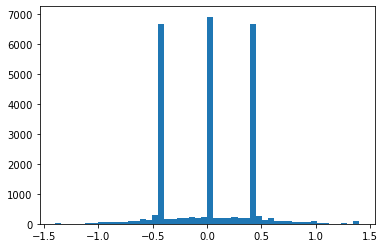

In [4]:
plt.hist(y, 50);

0.0


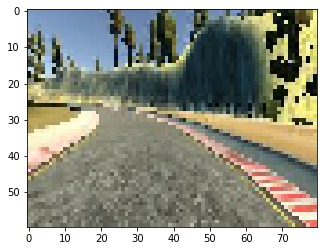

0.4


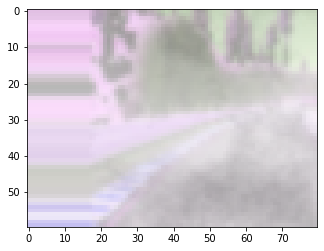

In [5]:
def augment(img, steering_angle):
    # Flip
    if random.random() > 0.5:
        img = img[:, ::-1, :]
        steering_angle = -steering_angle
    # Blur
    blurer = iaa.GaussianBlur(iap.Uniform(0.1, 1))
    img = blurer.augment_image(img)
    # Shuffle
    sh = iaa.ChannelShuffle(p=0.5)
    img = sh.augment_image(img)
    # Fog
    fog = iaa.Fog()
    img = fog.augment_image(img)
    # Translate
    tx = random.randint(-20,20)
    translator = iaa.Affine(translate_px={"x":tx}, mode='edge')
    img = translator.augment_image(img)
    steering_angle += tx*0.025
    
    return img, steering_angle

plt.imshow(X[0])
print(y[0])
plt.show()

img, angle = augment(X[0], y[0])
plt.imshow(img)
print(angle)
plt.show()

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(20188, 60, 80, 3) (20188,)
(5048, 60, 80, 3) (5048,)


In [8]:
Xgen=[]
ygen=[]
for i in range(X_train.shape[0]):
    img, angle = augment(X[i],y[i])
    Xgen.append(img)
    ygen.append(angle)
    
Xgen = np.array(Xgen)
ygen = np.array(ygen)
print(Xgen.shape, ygen.shape)

(20188, 60, 80, 3) (20188,)


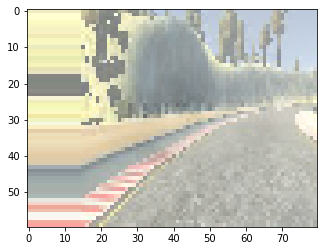

In [9]:
plt.imshow(Xgen[0])
plt.show()

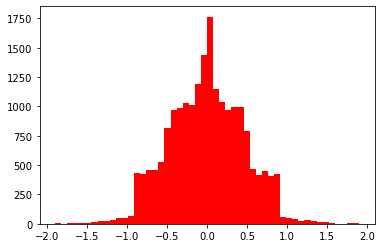

In [10]:
#plt.hist(y_train, 50, facecolor='green');
plt.hist(ygen, 50, facecolor='red');

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda
from livelossplot import PlotLossesKeras

In [25]:
def myModel(input_shape):
    model = Sequential([
        Lambda(lambda x: (x-128.0)/255.0, input_shape=input_shape, name='normalize'),
        Conv2D(64,(3,3), activation='relu'),
        Conv2D(32,(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(16,(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(8,(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(rate=0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(rate=0.3),
        Dense(512, activation='relu'),
        Dropout(rate=0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    return model

model = myModel(X[0].shape)
model.summary()
model.compile('adam','mse')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 26, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 13, 18, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 11, 16, 8)        

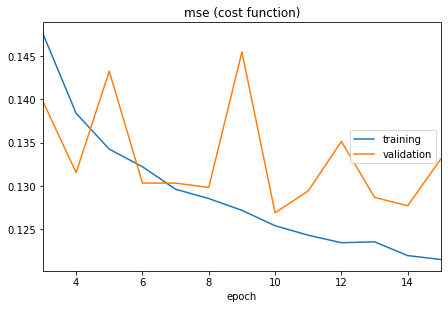

mse (cost function):
training   (min:    0.122, max:    0.186, cur:    0.122)
validation (min:    0.127, max:    0.146, cur:    0.133)


In [29]:
batch_size = 512
epochs = 15

model.fit(Xgen, ygen, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data=(X_val, y_val), 
          callbacks=[PlotLossesKeras()])

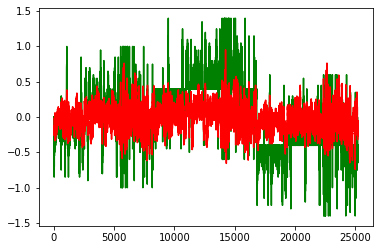

In [30]:
ypred = model.predict(X)
plt.plot(y,'g',ypred,'r')

In [33]:
model.save('beta_simulator_windows\mymodel.h5')

In [ ]:
import autokeras as ak

In [ ]:
model_ak = ak.ImageRegressor(verbose=True)
model_ak.fit(Xgen, ygen, time_limit=30*60)

In [ ]:
score = model_ak.evaluate(X_val, y_val)
print(score)

In [ ]:
ypred = model_ak.predict(X)

In [ ]:
plt.plot(y, 'g', ypred, 'r')
plt.show()

In [ ]:
#model_ak.export_keras_model('autokeras.h5')
model_ak.export_autokeras_model('autokerasmodel.pkl')

In [ ]:
from autokeras.utils import pickle_from_file
model = pickle_from_file(autokerasmodel.pkl)

In [ ]:
yp = model.predict(X_val)